# Exam image/video analysis
8264937 Sarah Hsu

# Question 2
Come up with a Google Images query you want to research, explain your choice, and collect at least 50 images from this query.
Then analyze the images using one of the methods we explored in week 4, 5 or 6. Make sure to motivate your choice of method: why are the image features you chose relevant in the context of your query? Interpret the results and discuss what other features could be relevant to analyze.

###• Motivation for your query and method (ca. 200 words)
As a student, I am wondering what is a typical image or public stereotype of a teacher and what kind of expression that people expect to a teacher from Google Images. Based on the motivation, I would like to look into the cultural representations of "teachers" and analyze the image features of gender and emotion.

First, I download 100 images with the keyword of "teacher" by `google-images-download`. However, in order to make sure our images are justified, I will filter out the images which are not directly relevant to teacher (for example some pictures are related to classrooms, books or some are not detected with a human face) and only select images with one face by `Face detection` method.

Secondly, I will apply the measure of `Gender classification` and `Emotion recognition` to analyze faces from the selected images. To work efficiently, I loop over these images and functions of image features then put these results into dataframe. 

Finally, in order to illustrate the results clearly and compare the differences, I will apply a bar plot to visualize the amounts of teacher images by gender and a line plot to demonstrate the relationship between male and female pictures in different emotions.

## Get the image from google

In [ ]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

  Cloning https://github.com/Joeclinton1/google-images-download.git to /tmp/pip-req-build-l9914a3d
  Running command git clone -q https://github.com/Joeclinton1/google-images-download.git /tmp/pip-req-build-l9914a3d


In [ ]:
from google_images_download import google_images_download  

response = google_images_download.googleimagesdownload()   #class instantiation
# download 100 pictures with keyword of "teacher"
arguments = {"keywords":"teacher", "limit":100, "print_urls": True}  
paths = response.download(arguments)   #passing the arguments to the function
print(paths)

In [ ]:
import io
import urllib
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
%config InlineBackend.figure_format='retina' 

def load_image_from_path(image_path, target_size=None, color_mode='rgb'):
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Face detection

In [ ]:
import cv2
import numpy as np

In [ ]:
import os
import pandas as pd
from pandas import DataFrame
file_list = os.listdir('/content/downloads/teacher') #filename
df = pd.DataFrame(file_list, columns= ['image'])
# put the images' paths into df
df['Path'] = df['image'].apply(lambda x: '/content/downloads/teacher/' + x)

In [ ]:
from tqdm.notebook import tqdm

# use the classifier in the manual 
face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  # only specify the classifier once!

n_faces = []
for file in tqdm(df.Path): # loop over images
    pre_image = load_image_from_path(file, color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')  
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) 
    n_faces.append(len(faces)) # append results to list

# create a column with the results of face detection
df['n_faces'] = n_faces 


  0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# select images with 1 face to analyze
df_1face = df[df.n_faces == 1]
df_1face.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 3 to 96
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    55 non-null     object
 1   Path     55 non-null     object
 2   n_faces  55 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ KB


##Gender classification

In [ ]:
!wget https://github.com/oarriaga/face_classification/raw/master/trained_models/gender_models/gender_mini_XCEPTION.21-0.95.hdf5
from tensorflow.keras.models import load_model

def apply_offsets(face_coordinates, offsets):
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

# use the classifier in the manual 
gender_classifier = load_model('gender_mini_XCEPTION.21-0.95.hdf5') # load this only once! 

GENDER_OFFSETS = (10, 10)
INPUT_SHAPE_GENDER = gender_classifier.input_shape[1:3]

labels = ['woman', 'man']

gender = []
for file in tqdm(df_1face.Path): # loop over images
    pre_image = load_image_from_path(file, color_mode='grayscale') 
    gray_image = np.squeeze(pre_image).astype('uint8')  
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) 
    for face_coordinates in faces: # using the output of the CascadeClassifier
      x1, x2, y1, y2 = apply_offsets(face_coordinates, GENDER_OFFSETS) # extends the bounding box
      face_img = gray_image[y1:y2, x1:x2] # only get the face 
      face_img = cv2.resize(face_img, (INPUT_SHAPE_GENDER)) # resize the image
      face_img = face_img.astype('float32') / 255.0 # preprocess the image
      face_img = np.expand_dims(face_img, 0) # batch of one
      probas = gender_classifier.predict(face_img) 
      gender.append(labels[np.argmax(probas[0])])

# create a column with the results of gender classification
df_1face['gender'] = gender 

  0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##Emotion recognition

In [ ]:
!wget https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5      

# use the classifier in the manual 
emotion_classifier = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5') # load this only once! (not in a loop)

EMOTION_OFFSETS = (0, 0)
INPUT_SHAPE_EMOTION = emotion_classifier.input_shape[1:3]

# set the labels of emotions
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
emotion = []
for file in tqdm(df_1face.Path): # loop over images
    pre_image = load_image_from_path(file, color_mode='grayscale') 
    gray_image = np.squeeze(pre_image).astype('uint8') 
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5)  
    for face_coordinates in faces:
        x1, x2, y1, y2 = apply_offsets(face_coordinates, EMOTION_OFFSETS) 
        face_img = gray_image[y1:y2, x1:x2] # only get the face
        face_img = cv2.resize(face_img, (INPUT_SHAPE_EMOTION))
        face_img = face_img.astype('float32') / 255.0 # pre-processing 
        face_img = face_img - 0.5 # pre-processing specific to the emotion classifier
        face_img = face_img * 2.0 # pre-processing specific to the emotion classifier
        face_img = np.expand_dims(face_img, 0) # batch of one
        face_img = np.expand_dims(face_img, -1) # pre-processing specific to the emotion classifier
        probas = emotion_classifier.predict(face_img)
        label = labels[np.argmax(probas[0])]
        emotion.append(label)

# create a column with the results of emotion recognition
df_1face['emotion'] = emotion

--2022-01-16 17:37:41--  https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/oarriaga/face_classification/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5 [following]
--2022-01-16 17:37:41--  https://raw.githubusercontent.com/oarriaga/face_classification/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 872856 (852K) [application/octet-stream]
Saving to: ‘fer2013_mini_XCEPTION.102-0.

  0%|          | 0/55 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_1face.head()

,image,Path,n_faces,gender,emotion
3,40.1140-nrta-overall-banner-teacher-portrait.jpg,/content/downloads/teacher/40.1140-nrta-overal...,1,man,happy
5,1.file-20210906-23-1mk17he.jpg,/content/downloads/teacher/1.file-20210906-23-...,1,man,happy
6,35.blank-template-2022-01-11t170922.727.jpg,/content/downloads/teacher/35.blank-template-2...,1,man,neutral
8,77..jpg,/content/downloads/teacher/77..jpg,1,man,happy
10,86.fa7cb455-e1bf-4e80-ac28-6a28e205a365-2060x1...,/content/downloads/teacher/86.fa7cb455-e1bf-4e...,1,man,neutral


In [ ]:
gender = df_1face.groupby(['gender']).sum()
gender

,n_faces
gender,
man,30
woman,25


## Visualization

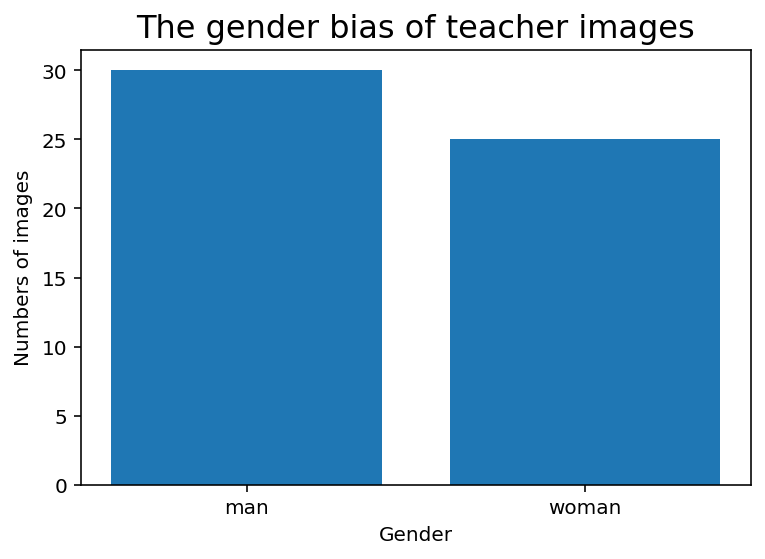

In [ ]:
import matplotlib.pyplot as plt

# Visualize the numbers of images by gender
gender = df_1face.groupby(['gender']).sum()
plt.bar(gender.index, gender.n_faces)

# set the labels and fontsizes
plt.title("The gender bias of teacher images", fontsize=16)
plt.xlabel("Gender")
plt.ylabel("Numbers of images")
plt.show()

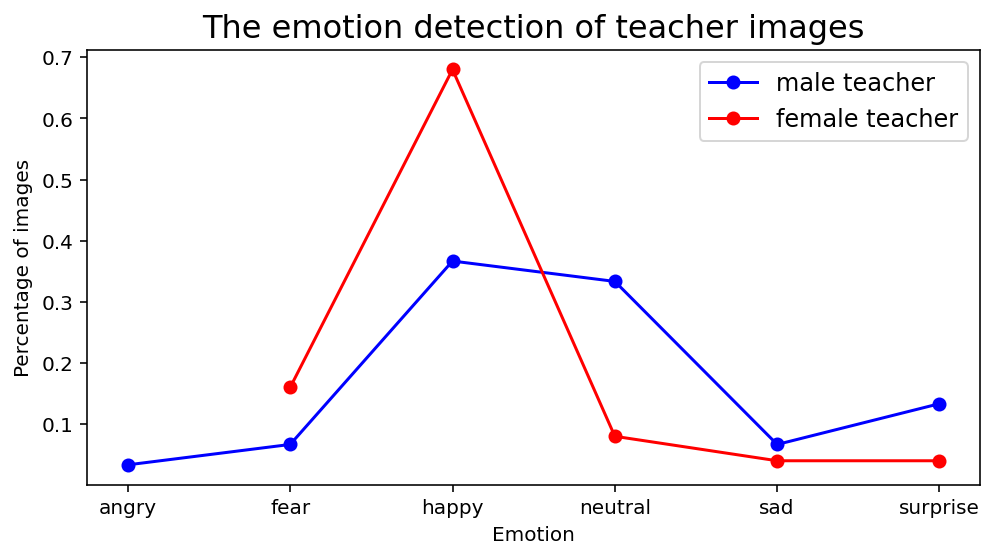

In [ ]:
# calculate the numbers of emotions by gender
man = df_1face[df_1face.gender == 'man'].groupby('emotion').sum()
woman = df_1face[df_1face.gender == 'woman'].groupby('emotion').sum()

plt.figure(figsize=(8,4))
# convert count value into percentage to avoid unjustified evaluation
plt.plot(man/man.sum(), label= "male teacher", color='blue', marker='o')
plt.plot(woman/woman.sum(), label= "female teacher", color='red', marker='o')

# set the labels and fontsizes
plt.title("The emotion detection of teacher images", fontsize=16)
plt.xlabel("Emotion")
plt.ylabel("Percentage of images")
plt.legend(fontsize=12)
plt.show()

###• Conclusion and discussion (ca. 200 words)
Based on the above dataframe results and the bar plot, we can find there is no significant gender bias toward male or female in the position of teacher (30 images of male : 25 images in female). 

Moreover, the line plot depicts that the images with happy emotion have the highest percentages in both male and female teachers.
However, there is a notable difference between the two gender distributions that the majority of emotions of female are detected as happy faces, with the proportion around 70% which is almost twice as much as the percentage of the male's one. In this case, I reckon people tend to expect female teachers to be more friendly and kind than male teachers. In my opinion, it also indicates a gender bias in human behavior that women should keep positive emotion whereas men are more likely to play the serious role in the society.

In conclusion, the typical identification of a teacher not only focus on male or female but people expect teachers to have a positive attitude, especially to woman. In my perspective, the analysis provides us a good insight into the gender image of occupations and social expectation in reality. 